# Sunspots forecasting sequence to sequence

In [1]:
%load_ext autoreload
%autoreload 2

## Install `tfutils`

In [1]:
!pip install -e /content/drive/MyDrive/projects/tfutils

Obtaining file:///content/drive/MyDrive/projects/tfutils
  Running setup.py develop for tfutils


## Some imports

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import losses, callbacks, optimizers, layers
from tfutils.timeseries import windowed_dataset, plot_series
from tfutils.visualize import plot_learning_curve
import matplotlib.pyplot as plt

## Sunspots Data

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2021-07-26 06:24:10--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.128, 74.125.204.128, 64.233.189.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2021-07-26 06:24:10 (128 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



In [4]:
df = pd.read_csv('/tmp/sunspots.csv').iloc[:, 1:]
df.head()

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


In [5]:
df.shape

(3235, 2)

In [6]:
series = df['Monthly Mean Total Sunspot Number']
time = pd.to_datetime(df['Date'])

## Split into train and test sets

In [7]:
split_time = 3000

x_train = series[:split_time]
time_train = time[:split_time]

x_test = series[split_time:]
time_test = time[split_time:]


## Make a windowed dataset

In [91]:
WINDOW_SIZE = 60
BATCH_SIZE = 100
SHUFFLE_BUFFER = 1000

In [92]:
def make_windowed_dataset(series, window_size, batch_size, shuffle_buffer=None):

    series = tf.expand_dims(series, axis=-1)

    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))

    if shuffle_buffer is not None:
        dataset = dataset.shuffle(shuffle_buffer)

    dataset = dataset.map(lambda window: (window[:-1], window[1:]))
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [93]:
test_dataset = make_windowed_dataset(series[split_time-WINDOW_SIZE:], WINDOW_SIZE, BATCH_SIZE, None)

## Create Model

In [100]:
tf.random.set_seed(51)
np.random.seed(51)

train_dataset = make_windowed_dataset(x_train, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER)

model = tf.keras.models.Sequential([
    layers.Conv1D(filters=60, kernel_size=5, strides=1, padding='causal',
                  activation='relu', input_shape=(None, 1)),
    layers.LSTM(units=60, return_sequences=True),
    layers.LSTM(units=60, return_sequences=True),
    layers.Dense(30, activation='relu'),
    layers.Dense(10, activation='relu'),
    layers.Dense(1),
    layers.Lambda(lambda x: x * 400)
])

lr_scheduler = callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))

model.compile(loss=losses.Huber(), optimizer=optimizers.SGD(learning_rate=1e-8, momentum=0.9),
              metrics=['mae'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, None, 60)          360       
_________________________________________________________________
lstm_4 (LSTM)                (None, None, 60)          29040     
_________________________________________________________________
lstm_5 (LSTM)                (None, None, 60)          29040     
_________________________________________________________________
dense_6 (Dense)              (None, None, 30)          1830      
_________________________________________________________________
dense_7 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_8 (Dense)              (None, None, 1)           11        
_________________________________________________________________
lambda_2 (Lambda)            (None, None, 1)          

In [101]:
%%time

history = model.fit(train_dataset, epochs=100, callbacks=[lr_scheduler], verbose=0)

CPU times: user 1min 15s, sys: 7.8 s, total: 1min 23s
Wall time: 59.5 s


### Loss vs Learning Rate

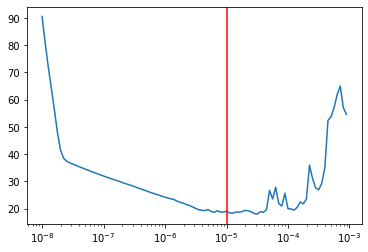

In [102]:
plt.semilogx(history.history['lr'], history.history['loss']);
plt.axvline(1e-5, color='red');

### recompile and fit the model

In [104]:
%%time 
tf.random.set_seed(51)
np.random.seed(51)

model = tf.keras.models.clone_model(model)

best_lr = 1e-5
model.compile(loss=losses.Huber(), optimizer=optimizers.SGD(learning_rate=best_lr, momentum=0.9), 
              metrics=['mae'])
history = model.fit(train_dataset, epochs=500, verbose=1);

Epoch 1/500
30/30 [==============================] - 3s 13ms/step - loss: 70.0143 - mae: 70.5124
Epoch 2/500
30/30 [==============================] - 1s 14ms/step - loss: 30.9973 - mae: 31.4926
Epoch 3/500
30/30 [==============================] - 1s 14ms/step - loss: 25.8922 - mae: 26.3866
Epoch 4/500
30/30 [==============================] - 1s 14ms/step - loss: 23.0327 - mae: 23.5263
Epoch 5/500
30/30 [==============================] - 1s 14ms/step - loss: 21.8150 - mae: 22.3085
Epoch 6/500
30/30 [==============================] - 1s 14ms/step - loss: 21.4852 - mae: 21.9784
Epoch 7/500
30/30 [==============================] - 1s 15ms/step - loss: 21.6455 - mae: 22.1392
Epoch 8/500
30/30 [==============================] - 1s 14ms/step - loss: 20.8642 - mae: 21.3575
Epoch 9/500
30/30 [==============================] - 1s 14ms/step - loss: 20.4565 - mae: 20.9498
Epoch 10/500
30/30 [==============================] - 1s 14ms/step - loss: 19.8353 - mae: 20.3284
Epoch 11/500
30/30 [=========

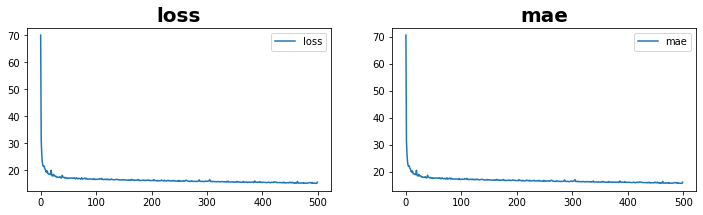

In [105]:
plot_learning_curve(history, extra_metric='mae');

In [107]:
forecast = model.predict(test_dataset)

In [108]:
from tfutils.utils import get_labels_from_tfdataset

In [109]:
y_test = get_labels_from_tfdataset(test_dataset)

In [110]:
forecast.shape

(235, 60, 1)

In [111]:
y_test.shape

TensorShape([235, 60, 1])

In [112]:
model.evaluate(test_dataset)

3/3 [==============================] - 1s 8ms/step - loss: 15.5684 - mae: 16.0560


[15.568410873413086, 16.056028366088867]

In [113]:
tf.reduce_mean(tf.keras.metrics.mean_absolute_error(y_test, forecast))

<tf.Tensor: shape=(), dtype=float32, numpy=16.056028>

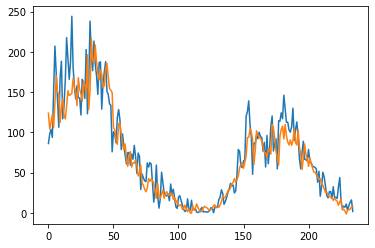

In [114]:
forecast_one_day_test = forecast[:, -1, 0]

plt.plot(x_test.to_numpy(), label='actual')
plt.plot(forecast_one_day_test, label='predicted');

In [116]:
tf.keras.metrics.mean_absolute_error(x_test, forecast_one_day_test)

<tf.Tensor: shape=(), dtype=float32, numpy=15.775521>